In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA # type: ignore
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [6]:
from data_fetcher import fetch_stock_data
end_date = pd.to_datetime('today').strftime('%Y-%m-%d')
data = fetch_stock_data("TSLA", start_date="2014-01-01", end_date=end_date)
data

[*********************100%***********************]  1 of 1 completed


,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2014-01-02 00:00:00+00:00,10.006667,10.006667,10.165333,9.770000,9.986667,92826000
2014-01-03 00:00:00+00:00,9.970667,9.970667,10.146000,9.906667,10.000000,70425000
2014-01-06 00:00:00+00:00,9.800000,9.800000,10.026667,9.682667,10.000000,80416500
2014-01-07 00:00:00+00:00,9.957333,9.957333,10.026667,9.683333,9.841333,75511500
2014-01-08 00:00:00+00:00,10.085333,10.085333,10.246667,9.917333,9.923333,92448000
...,...,...,...,...,...,...
2024-11-11 00:00:00+00:00,350.000000,350.000000,358.640015,336.000000,346.299988,210521600
2024-11-12 00:00:00+00:00,328.489990,328.489990,345.839996,323.309998,342.739990,155726000
2024-11-13 00:00:00+00:00,330.239990,330.239990,344.600006,322.500000,335.850006,125405600


# Visualize The Stock's Daily Closing Price

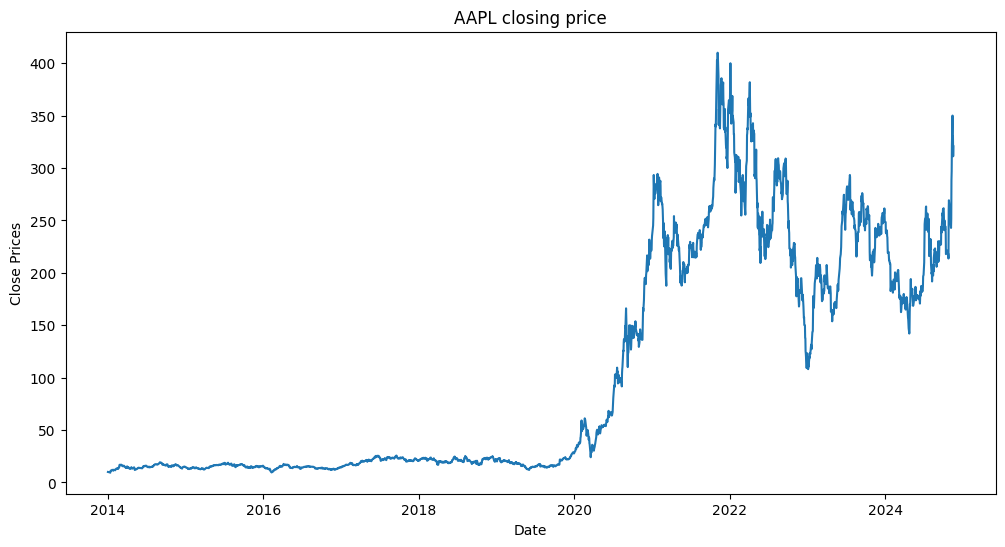

In [7]:
plt.figure(figsize=(12, 6))
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(data['Close'])
plt.title('AAPL closing price')
plt.show()

Using probability distribution to visualize our data

<Axes: ylabel='Density'>

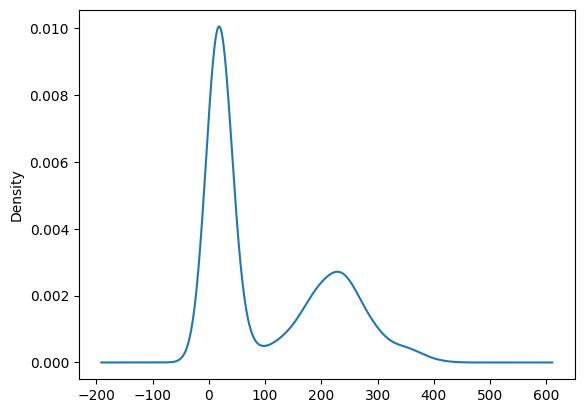

In [8]:
df_close = data['Close']
df_close.plot(kind='kde')

## Test for Stationarity
 A stationarity in a time series means that its statistical properties like mean and variance do not change over time. This stability is crucial because most forecasting models require the series to be stationary to produce reliable results. Non-stationary series, which show trends or seasonal variations, often need adjustments such as differencing or transformation to achieve stationarity.

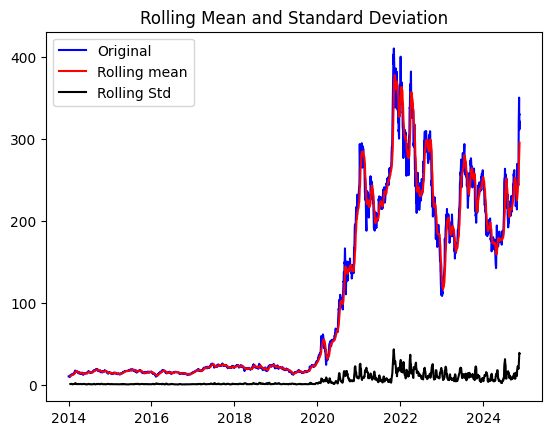

In [9]:
# Rollling mean
rolling_mean = df_close.rolling(12).mean()
rolling_std = df_close.rolling(12).std()
# Plot
plt.plot(df_close, color='blue', label='Original')
plt.plot(rolling_mean, color='red', label='Rolling mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean and Standard Deviation')
plt.show(block=False);

Check using Dickey Fuller test

In [10]:
adf_res = adfuller(df_close, autolag='AIC')
output = pd.Series(adf_res[0:4], index=['Test Statistics', 'p-value', 'No. of lags used','No. of observations'])

for key, values in adf_res[4].items():
    output[f'critical_value {key}'] = values

print(output)

Test Statistics          -0.710497
p-value                   0.844012
No. of lags used         28.000000
No. of observations    2709.000000
critical_value 1%        -3.432766
critical_value 5%        -2.862608
critical_value 10%       -2.567338
dtype: float64


We can decompose the time series to separate the trend and seasonality from a time series.

<Figure size 640x480 with 0 Axes>

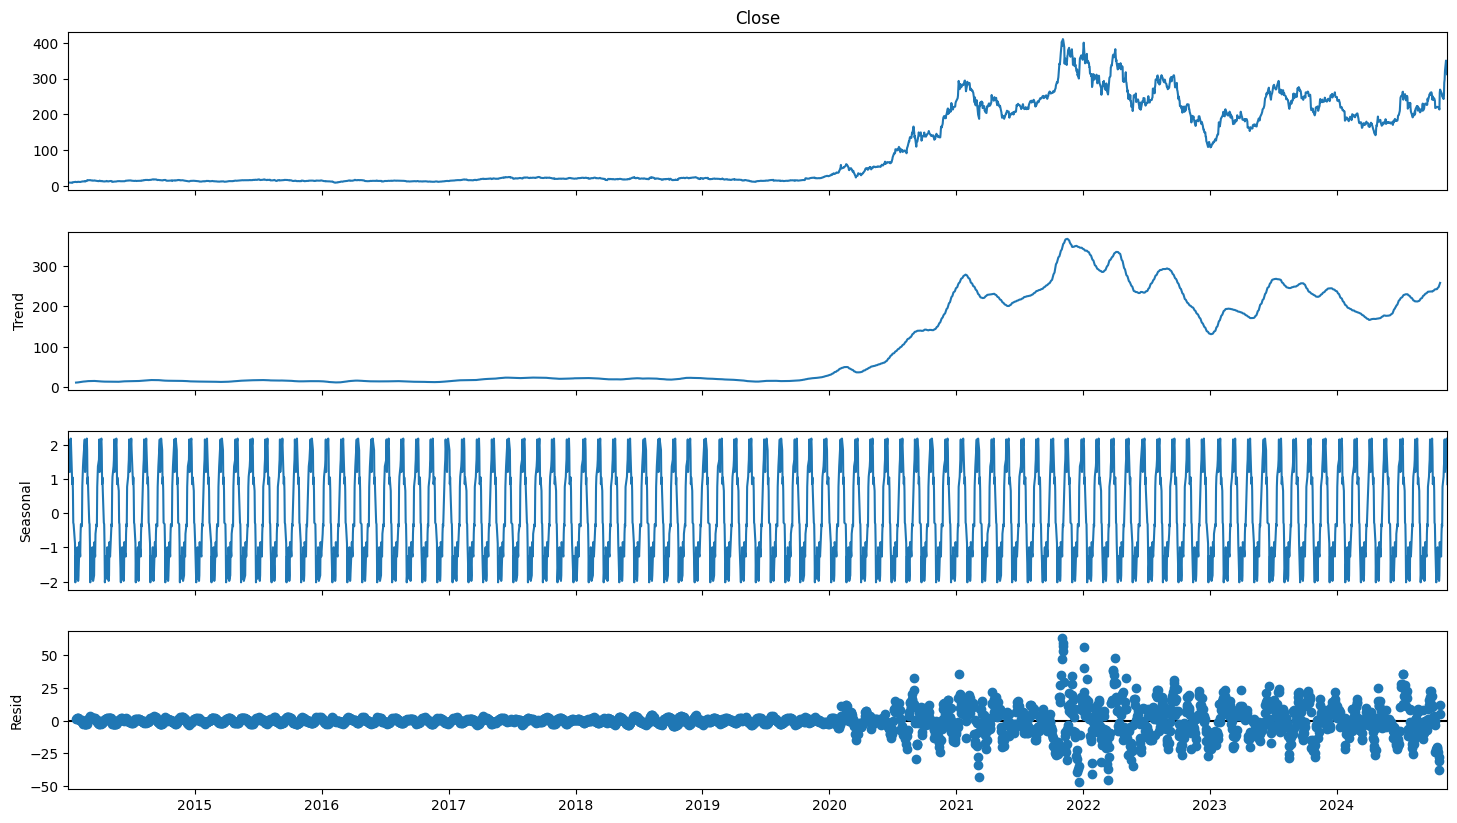

In [11]:
result = seasonal_decompose(df_close, model='additive', period=30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)

Now we eliminate the trend. There are different ways of doing that. We will be doing a log transformation.

In [13]:
# df_log = np.log(df_close)

# moving_avg = df_log.rolling(12).mean()
# std_dev = df_log.rolling(12).std()
# plt.plot(moving_avg, color='red', label='Mean')
# plt.plot(std_dev, color='black', label='Standard Deviation')
# plt.legend(loc='best')
# plt.title('Mean and Standard Deviation')
# plt.show();

df_diff = df_close.diff()
df_diff.dropna(inplace=True)
df_diff.head()

Date
2014-01-03 00:00:00+00:00   -0.036000
2014-01-06 00:00:00+00:00   -0.170667
2014-01-07 00:00:00+00:00    0.157332
2014-01-08 00:00:00+00:00    0.128000
2014-01-09 00:00:00+00:00   -0.250000
Name: Close, dtype: float64

In [14]:
df_diff.isnull().sum()

0

In [15]:
adf_res = adfuller(df_diff, autolag='AIC')
output = pd.Series(adf_res[0:4], index=['Test Statistics', 'p-value', 'No. of lags used','No. of observations'])

for key, values in adf_res[4].items():
    output[f'critical_value {key}'] = values

print(output)

Test Statistics       -9.965897e+00
p-value                2.307602e-17
No. of lags used       2.800000e+01
No. of observations    2.708000e+03
critical_value 1%     -3.432767e+00
critical_value 5%     -2.862608e+00
critical_value 10%    -2.567338e+00
dtype: float64


Split the Data into Training and Test sets

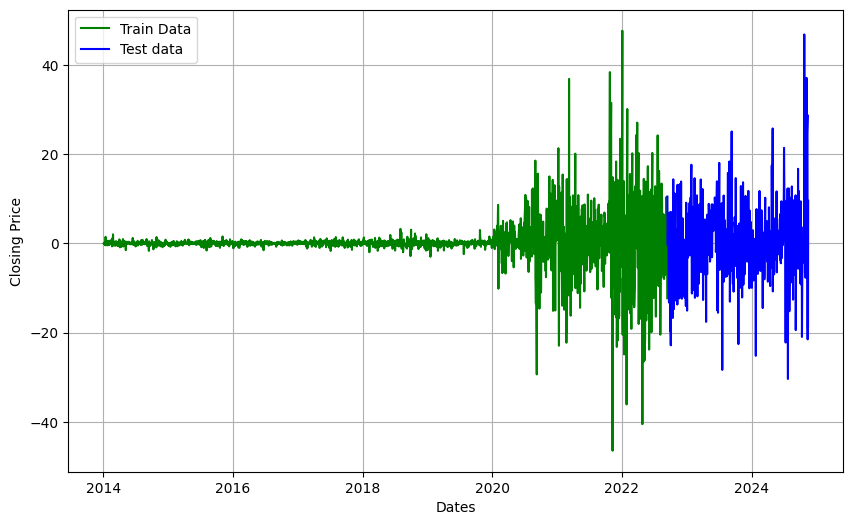

In [16]:
cutoff = int(len(df_diff) * 0.8)
train_data = df_diff[:cutoff]
test_data = df_diff[cutoff:]

plt.figure(figsize=(10, 6))
plt.grid('True')
plt.xlabel('Dates')
plt.ylabel('Closing Price')
plt.plot(train_data, 'green',label='Train Data')
plt.plot(test_data, 'blue',label='Test data')
plt.legend()
plt.show()

The p parameter in the ARIMA model denotes the number of lag observations included in the model, reflecting the autoregressive part that predicts future values based on past values. The d parameter represents the degree of differencing required to make the data stationary, addressing trends or seasonal effects by subtracting previous observations from current ones. Lastly, q indicates the size of the moving average window, which incorporates the dependency of an observation on a residual error from a moving average model applied to lagged observations. Understanding these parameters is crucial as they directly impact the model’s ability to capture the underlying patterns in the time series data.

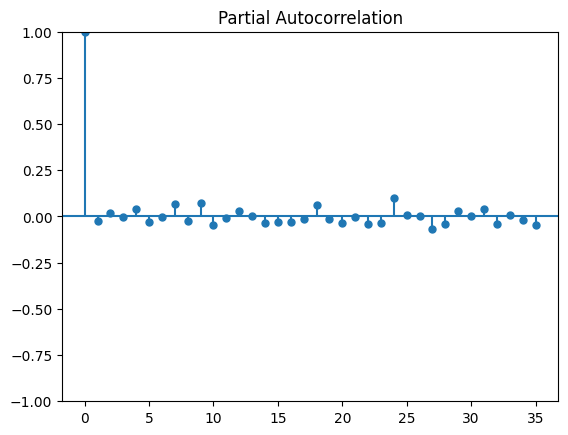

In [17]:
from pmdarima import plot_acf, plot_pacf


plot_pacf(df_diff)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=13306.269, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=13305.095, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=13305.083, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=13305.694, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=13307.082, Time=0.18 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=13307.081, Time=0.24 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=13304.192, Time=0.52 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=13310.713, Time=1.00 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=13308.963, Time=0.24 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=13309.078, Time=0.22 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=13259.126, Time=1.64 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=13282.369, Time=1.65 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=13278.538, Time=2.17 sec
 ARIMA(1,0,4)(0,0,0)[0] i

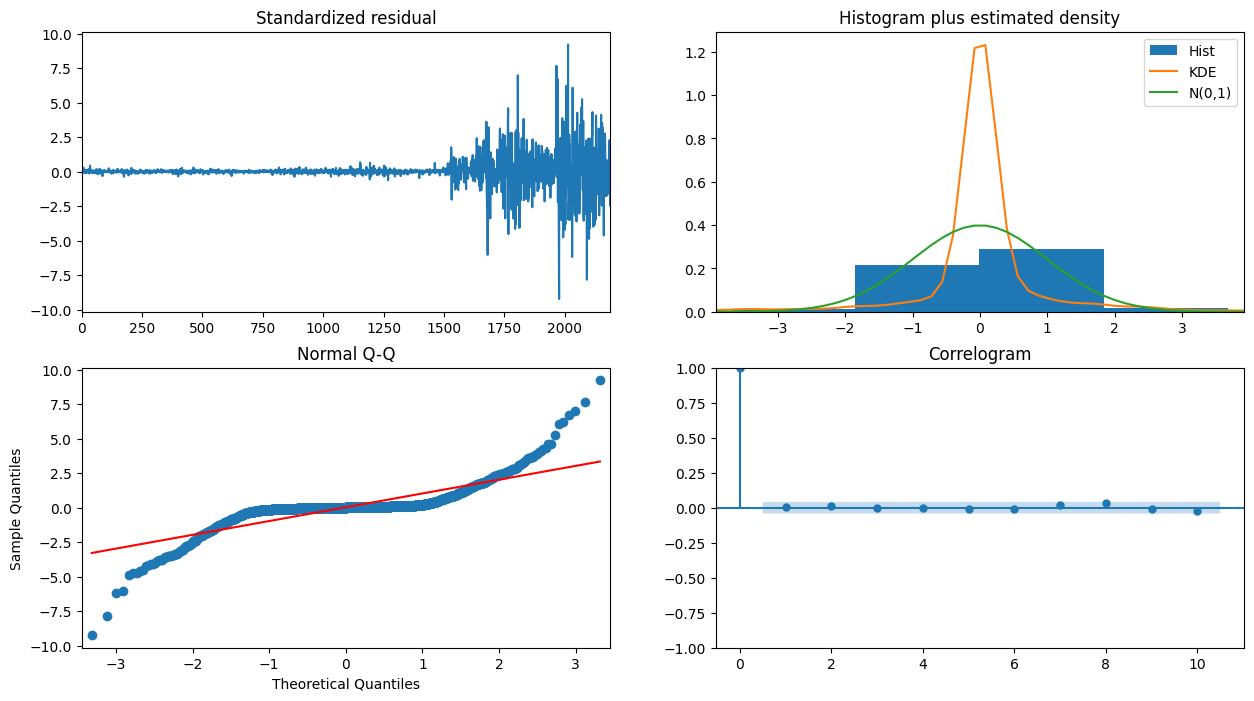

In [31]:
auto_model = auto_arima(train_data, 
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True
                        )

print(auto_model.summary())
auto_model.plot_diagnostics(figsize=(15,8))
plt.show();

**The Auto ARIMA model assigned the values 0, 1 and 1 to p, d and q respectively**

Build model

In [32]:
model = ARIMA(train_data, order=(2,0,3))
fitted = model.fit()
print(fitted.summary())

c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2189
Model:                 ARIMA(2, 0, 3)   Log Likelihood               -6622.563
Date:                Sat, 16 Nov 2024   AIC                          13259.126
Time:                        14:08:26   BIC                          13298.964
Sample:                             0   HQIC                         13273.687
                               - 2189                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1287      0.101      1.268      0.205      -0.070       0.328
ar.L1         -1.0653      0.013    -82.669      0.000      -1.091      -1.040
ar.L2         -0.8756      0.015    -59.636      0.0

In [ ]:
last_train_date = train_data.index[-1]
forecast_start_date= last_train_date + pd.Timedelta(days=1)
forecast_index = pd.date_range(start=forecast_start_date, periods=321, freq='D')

Timestamp('2022-11-23 00:00:00+0000', tz='UTC')

Modelling and Foreacsting

In [33]:
forecast_steps = len(test_data)
forecast = fitted.forecast(steps=forecast_steps)
forecast

c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


2189   -0.802365
2190    1.488433
2191    0.628126
2192   -1.593892
2193    1.526468
          ...   
2732    0.128700
2733    0.128700
2734    0.128700
2735    0.128700
2736    0.128700
Name: predicted_mean, Length: 548, dtype: float64

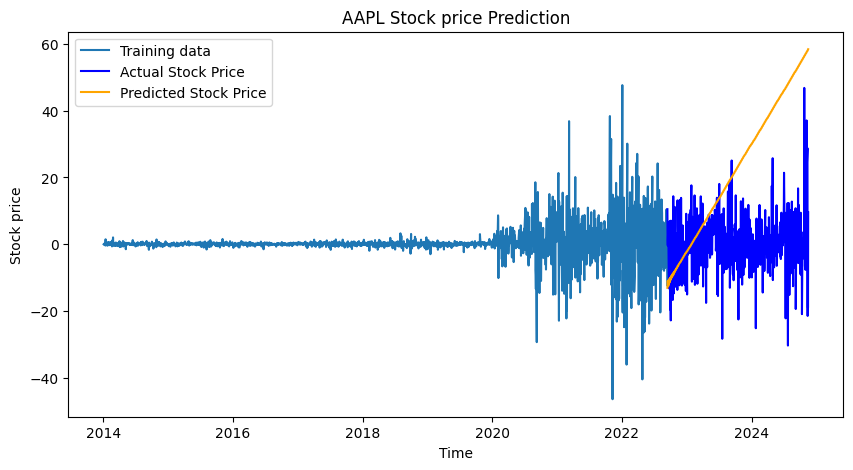

In [34]:

last_train_date = train_data.index[-1]
forecast_start_date= last_train_date + pd.Timedelta(days=1)
forecast_index = pd.date_range(start=forecast_start_date, periods=forecast_steps)
last_observed_value = train_data[-1]  # Last value from training data
forecast_reverted = last_observed_value + forecast.cumsum()

# make series
# f_index = pd.date_range(start=test_data.index[-1], periods=322, freq='M')[1:]
# fc_series = pd.Series(forecast, index=f_index)
# lower_series = pd.Series(result[1][:, 0], index=test_data.index)
# upper_series = pd.Series(result[1][:, 1], index=test_data.index)

# Plot
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_data, label='Training data')
plt.plot(test_data, color='blue', label='Actual Stock Price')
plt.plot(test_data.index,forecast_reverted, color='orange', label='Predicted Stock Price')
# plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.title('AAPL Stock price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock price')
plt.legend()
plt.show();

In [29]:
forecast

2189   -0.291598
2190    1.370159
2191   -0.232827
2192   -0.739810
2193    1.233449
          ...   
2732    0.127607
2733    0.127607
2734    0.127607
2735    0.127607
2736    0.127607
Name: predicted_mean, Length: 548, dtype: float64

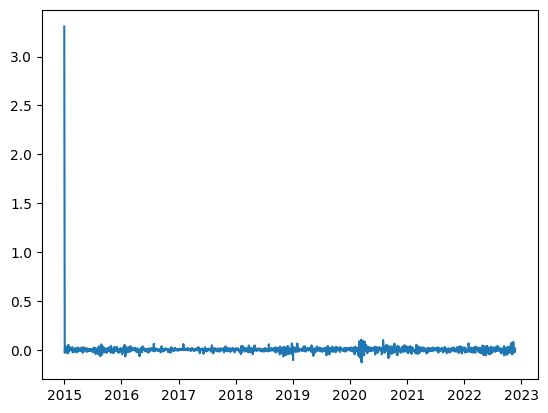

In [33]:
residuals = fitted.resid
plt.plot(residuals)
plt.show()

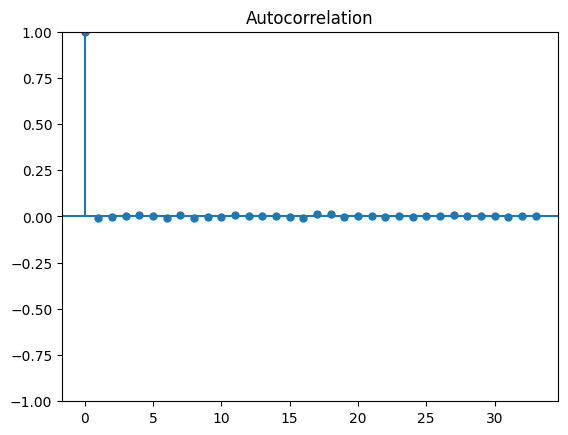

In [34]:
plot_acf(residuals)
plt.show()

In [36]:
print(type(forecast))

<class 'pandas.core.series.Series'>


In [48]:
len(test_data)

497

In [30]:
mse = mean_squared_error(test_data, forecast)
print("MSE: " + str(mse))
mae = mean_absolute_error(test_data, forecast)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, forecast))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(forecast - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 64.4163711614843
MAE: 5.747928384664135
RMSE: 8.025981009290037
MAPE: nan


In [ ]:
p_params = (0, 25, 8)
q_params = (0, 3, 1)

mae_grid = dict()
for p in p_params:
    mae_grid[p] = list()
    for q in q_params:
        order = (p, 1, q)
        model = ARIMA(train_data, order=order)
        model.fit()